<a href="https://colab.research.google.com/github/jiaminho/Pedestrian-Trajectory-Prediction-LSTM/blob/main/Pedestrian_Trajectory_Prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CITS5017 Deep Learning Project 1

Jia Min Ho (23337561)

https://github.com/jiaminho/Pedestrian-Trajectory-Prediction-LSTM

# Questions:
- loss ADE, metrics MSE??
- activation function, dropout, etc. required?
- prediction right or wrong? why my ade vs time step is smooth?
- how should the VAE look like? do we need to show the original trajectories?



# To do list:
- Rename to Ho_JiaMin-proj2.ipynb
- Add proper section number and headings
- Make model 1 and 2 modular so can accept any number of input and output for the comparison part
- Fix loss vs timestep curve (it should not be smooth!!)
- Make the comparison trajectories plots smaller and stick together to easier to see. Actually only need to plot 6/14 because questions didn't ask to plot all.


done:
- Improve second lstm model
- Print only every 10 epochs


**Import libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional, Concatenate

**Load data file**

In [ ]:
def load_data(filename):
  with open(filename, "rb") as f:
    train = np.load(f)
    val = np.load(f)
  return train, val

train_set, val_set = load_data("zara1.npy")

In [ ]:
train_set.shape

(26507, 20, 2)

train set is a 3D tensor of the shape (26507, 20, 2)

In [ ]:
val_set.shape

(2315, 20, 2)

val set is also a 3D tensor of the shape (2315, 20, 2)

In [ ]:
train_set[:2]

array([[[-0.31367778,  0.06750966],
        [-0.29939284,  0.04183492],
        [-0.28788528,  0.02332389],
        [-0.27795722,  0.00511593],
        [-0.27771266, -0.01810555],
        [-0.27427557, -0.0401845 ],
        [-0.26811742, -0.06929811],
        [-0.26960516, -0.09556106],
        [-0.2664506 , -0.12253553],
        [-0.25403196, -0.15084949],
        [-0.2478035 , -0.17821016],
        [-0.24339741, -0.21024651],
        [-0.23582799, -0.24103601],
        [-0.22989552, -0.27321961],
        [-0.22685222, -0.30169945],
        [-0.21930551, -0.33237906],
        [-0.21320741, -0.36119077],
        [-0.21341177, -0.39253789],
        [-0.20912005, -0.42605787],
        [-0.20061589, -0.4666159 ]],

       [[-0.29939284,  0.04183492],
        [-0.28788528,  0.02332389],
        [-0.27795722,  0.00511593],
        [-0.27771266, -0.01810555],
        [-0.27427557, -0.0401845 ],
        [-0.26811742, -0.06929811],
        [-0.26960516, -0.09556106],
        [-0.2664506 , -0.1

Each trajectory in each frame is a 2D point (x,y).

In [ ]:
# Set random seeds for reproducibility
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## 1. Split trajectories into observed and future

Split the trajectories into two parts: the observed part should contain the trajectory coordinates for
the first 12 frames; the future part should contain the trajectory coordinates for the remaining 8
frames.

In [ ]:
def split_trajectories(data, observed_len, future_len):
    # Variable length for observed and future parts
    observed = data[:, :observed_len, :]
    future = data[:, observed_len:observed_len + future_len, :]
    return observed, future

train_observed, train_future = split_trajectories(train_set, 12, 8)
val_observed, val_future = split_trajectories(val_set, 12, 8)

## 2. Plot Sampled Trajectories

Write a small function that takes in appropriate arguments so that it would randomly sample 30
trajectories and display them in 3 subplots (10 trajectories per subplot, to avoid crowdedness). The
observed part and the future part of each trajectory should be shown in different colours.
Call the function twice – for the training set then the validation set.

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# def display_sampled_trajectories(observed, true_future, predicted_future=None, title="Sampled Trajectories", seed=42):
#     np.random.seed(seed)  # For reproducibility
#     indices = np.random.choice(observed.shape[0], 30, replace=False)
#     fig, axs = plt.subplots(1, 3, figsize=(15, 5))
#     for i, ax in enumerate(axs):
#         for j in range(10):
#             index = indices[i*10 + j]
#             ax.plot(observed[index, :, 0], observed[index, :, 1], color='blue', marker='.', label='Observed' if j==0 else "")
#             ax.plot(true_future[index, :, 0], true_future[index, :, 1], color='red', marker='.', label='True Future' if j==0 else "")

#             # Join the end of observed to the start of true_future
#             ax.plot([observed[index, -1, 0], true_future[index, 0, 0]],
#                     [observed[index, -1, 1], true_future[index, 0, 1]], color='red')

#             # Check if predicted_future is provided
#             if predicted_future is not None:
#                 ax.plot(predicted_future[index, :, 0], predicted_future[index, :, 1], color='green', marker='.', label='Predicted Future' if j==0 else "")
#                 # Join the end of observed to the start of predicted_future
#                 ax.plot([observed[index, -1, 0], predicted_future[index, 0, 0]],
#                         [observed[index, -1, 1], predicted_future[index, 0, 1]], color='green')

#             ax.legend(loc='best')

#         ax.axis('equal')
#         ax.grid(True)  # Adding gridlines

#     plt.suptitle(title)
#     plt.tight_layout()
#     plt.show()


trying to fix the joined lines in VAE

In [ ]:
def display_sampled_trajectories(observed, true_future, predicted_future=None, title="Sampled Trajectories", seed=42, connect=True):
    np.random.seed(seed)  # For reproducibility
    indices = np.random.choice(observed.shape[0], 30, replace=False)
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    for i, ax in enumerate(axs):
        for j in range(10):
            index = indices[i*10 + j]
            ax.plot(observed[index, :, 0], observed[index, :, 1], color='blue', marker='.', label='Observed' if j==0 else "")
            ax.plot(true_future[index, :, 0], true_future[index, :, 1], color='red', marker='.', label='True Future' if j==0 else "")

            # Connect the end of observed to the start of true_future, if connect is True
            if connect:
                ax.plot([observed[index, -1, 0], true_future[index, 0, 0]],
                        [observed[index, -1, 1], true_future[index, 0, 1]], color='red')

            # Check if predicted_future is provided
            if predicted_future is not None:
                ax.plot(predicted_future[index, :, 0], predicted_future[index, :, 1], color='green', marker='.', label='Predicted Future' if j==0 else "")

                # Connect the end of observed to the start of predicted_future, if connect is True
                if connect:
                    ax.plot([observed[index, -1, 0], predicted_future[index, 0, 0]],
                            [observed[index, -1, 1], predicted_future[index, 0, 1]], color='green')

            ax.legend(loc='best')

        ax.axis('equal')
        ax.grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

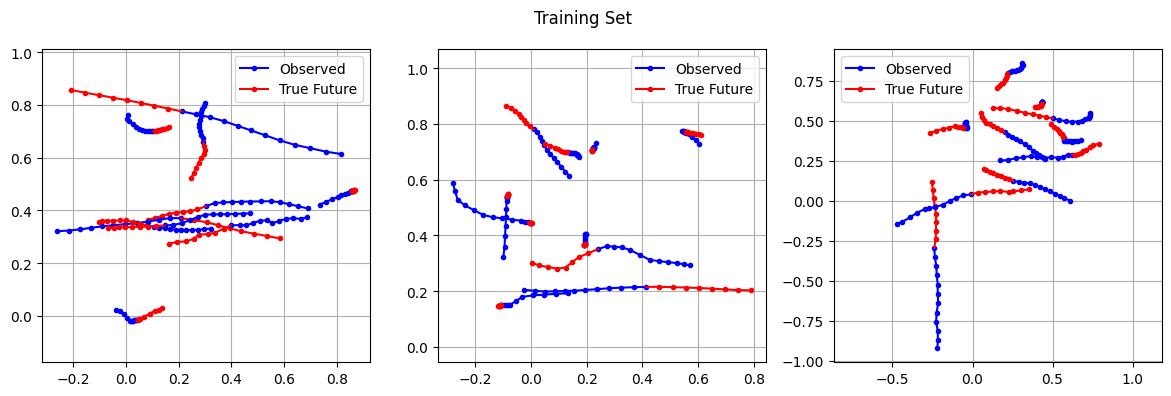

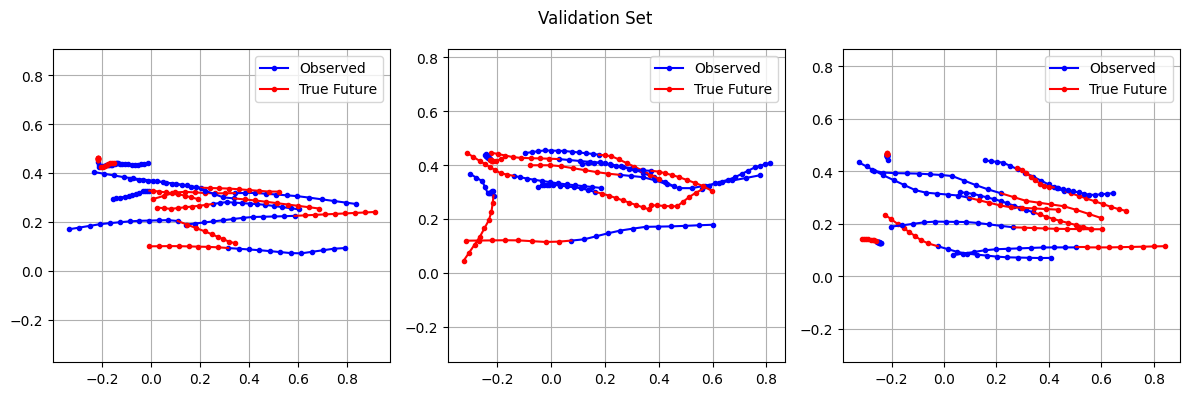

In [ ]:
# Call the function for training set
display_sampled_trajectories(train_observed, train_future, title="Training Set")

# Call the function for validation set
display_sampled_trajectories(val_observed, val_future, title="Validation Set")

## 3. First LSTM Model

(iii) Implementation of the first LSTM model (30% (the mark includes parts (i) and (ii) above))
- Design an LSTM that has 1 to 2 layers and an appropriate number of neurons per layer.
This LSTM should be trained to take in the observed part of the trajectories and predict the
pedestrians’ 2D coordinates for just the first frame in the future part (i.e., predict one timestep
ahead). Show the architecture of your LSTM network.
- You will need to write a function using the formula given in Equation (1) and use it as the
loss function for compiling and training your network, e.g., def ADE(y true, y pred).
- Train your network for 100 epochs but use an early stopping callback and the validation set
to prevent over-training.
- Show the learning curves plot.
- As this LSTM network can predict only the pedestrians’ coordinates for one timestep ahead,
use a for loop to recursively predict the remaining 7 frames in the future part of the trajectories.
- Report the ADE and FDE of this network.
- Illustrate 30 randomly sampled trajectories in some subplots. The observed part, the ground
truth future part and the predicted future part of these trajectories should be shown in different
colours.
If you have the function for part (ii) above designed well, you should be able to reuse the
function here.


Single Step LSTM: The first LSTM model predicts just one step into the future. This is a relatively simpler architecture where the LSTM is trained to map a sequence of observed trajectories to the next immediate trajectory point. After training, to predict multiple future steps, we use a for-loop to repeatedly input the predictions back into the LSTM.

**ADE** and **FDE** loss function:

In [ ]:
def ADE(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)))

def FDE(y_true_last_step, y_pred_last_step):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true_last_step - y_pred_last_step), axis=-1)))

Callback to print every 10th epoch

In [ ]:
# Print every 10th epoch
class PrintEvery10Epochs(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: val_loss = {logs['val_loss']}, loss = {logs['loss']}")

**First LSTM model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Design the LSTM
simple_model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(None, 2)),
    LSTM(16),
    Dense(2)  # To predict the x,y coordinates for the next timestep
])

# Compile the model
simple_model.compile(optimizer='adam', loss=ADE)

# Early stopping callback
early_stop_val_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
early_stop_loss = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

# Add custom callback to the list
callbacks_list=[PrintEvery10Epochs(), early_stop_val_loss, early_stop_loss]

# Train the model
history_simple_model = simple_model.fit(train_observed, train_future[:, 0, :],
                                        validation_data=(val_observed, val_future[:, 0, :]),
                                        epochs=100, callbacks=callbacks_list, batch_size=32, verbose=0)

Epoch 0: val_loss = 0.017061695456504822, loss = 0.06050748750567436
Epoch 10: val_loss = 0.004246682394295931, loss = 0.005513888783752918
Epoch 20: val_loss = 0.0033149172086268663, loss = 0.00457973126322031
Epoch 30: val_loss = 0.0022029741667211056, loss = 0.004258195869624615
Epoch 40: val_loss = 0.002748897997662425, loss = 0.004155251197516918


In [ ]:
simple_model.summary()  # Show the architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 32)          4480      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 2)                 34        
                                                                 
Total params: 7650 (29.88 KB)
Trainable params: 7650 (29.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Display the Learning Curves

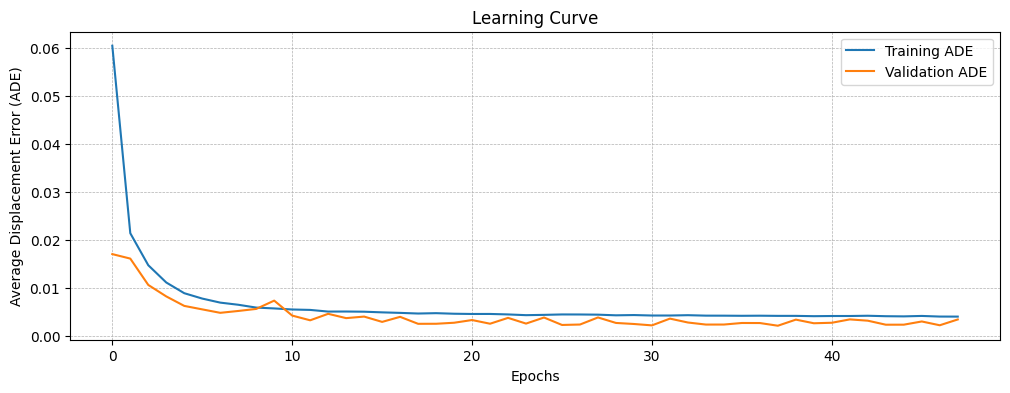

In [ ]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    # Plotting loss curves
    plt.plot(history.history['loss'], label='Training ADE')
    plt.plot(history.history['val_loss'], label='Validation ADE')

    # Adding gridlines
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Average Displacement Error (ADE)')
    plt.title('Learning Curve')

    plt.show()

plot_learning_curves(history_simple_model)

Predict Remaining 7 Frames and plot ADE vs Time Step

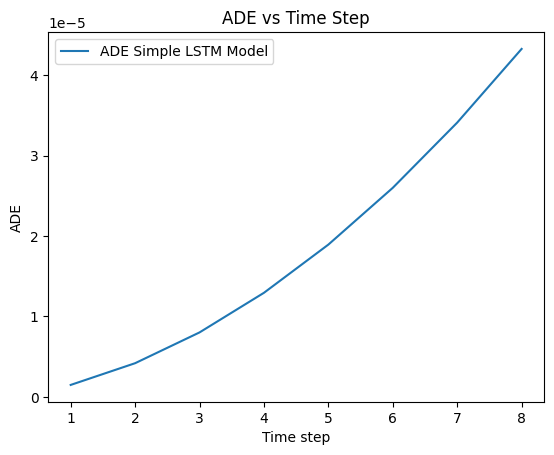

In [ ]:
# Initialize ADE arrays
ade_per_step_simple = np.zeros(8)
ade_per_step_encoder_decoder = np.zeros(8)
num_samples = val_observed.shape[0]

def predict_and_calculate_ade(observed, ground_truth, model, ade_per_step_array, future_len, is_encoder_decoder=False):
    predicted_future = np.zeros((observed.shape[0], future_len, 2))
    current_input = observed
    decoder_input = np.zeros((observed.shape[0], 1, 2))  # Placeholder for the decoder input

    for i in range(future_len):
        if is_encoder_decoder:
            next_step = model.predict([current_input, decoder_input], verbose=0)
        else:
            next_step = model.predict(current_input, verbose=0)

        if next_step.shape[1] == 1:
            next_step = next_step[:, 0, :]

        predicted_future[:, i, :] = next_step
        ade_this_step = np.mean(np.sqrt(np.sum(np.square(ground_truth[:, i, :] - next_step), axis=-1)))
        ade_per_step_array[i] += ade_this_step

        # Update the current input for the next iteration
        current_input = np.concatenate([current_input[:, 1:, :], next_step[:, np.newaxis, :]], axis=1)

    return predicted_future


# Calculate ADE for simple model
predicted_val_future_simple = predict_and_calculate_ade(val_observed, val_future, simple_model, ade_per_step_simple, 8)
ade_per_step_simple /= num_samples

# Plot ADE
plt.figure()
plt.plot(range(1, 9), ade_per_step_simple, label='ADE Simple LSTM Model')
plt.xlabel('Time step')
plt.ylabel('ADE')
plt.legend()
plt.title('ADE vs Time Step')
plt.show()


Calculate average displacement error (ADE) and final displacement error (FDE)



In [ ]:
# ADE & FDE using the predictions generated by the simple model
ade_simple = ADE(val_future, predicted_val_future_simple)
fde_simple = FDE(val_future[:, -1, :], predicted_val_future_simple[:, -1, :])
print(f"Simple Model - Average Displacement Error (ADE): {ade_simple:.4f}")
print(f"Simple Model - Final Displacement Error (FDE): {fde_simple:.4f}")

Simple Model - Average Displacement Error (ADE): 0.0431
Simple Model - Final Displacement Error (FDE): 0.1001


The values of ADE and FDE are low, indicating a good prediction.

**Display Sampled Trajectories**

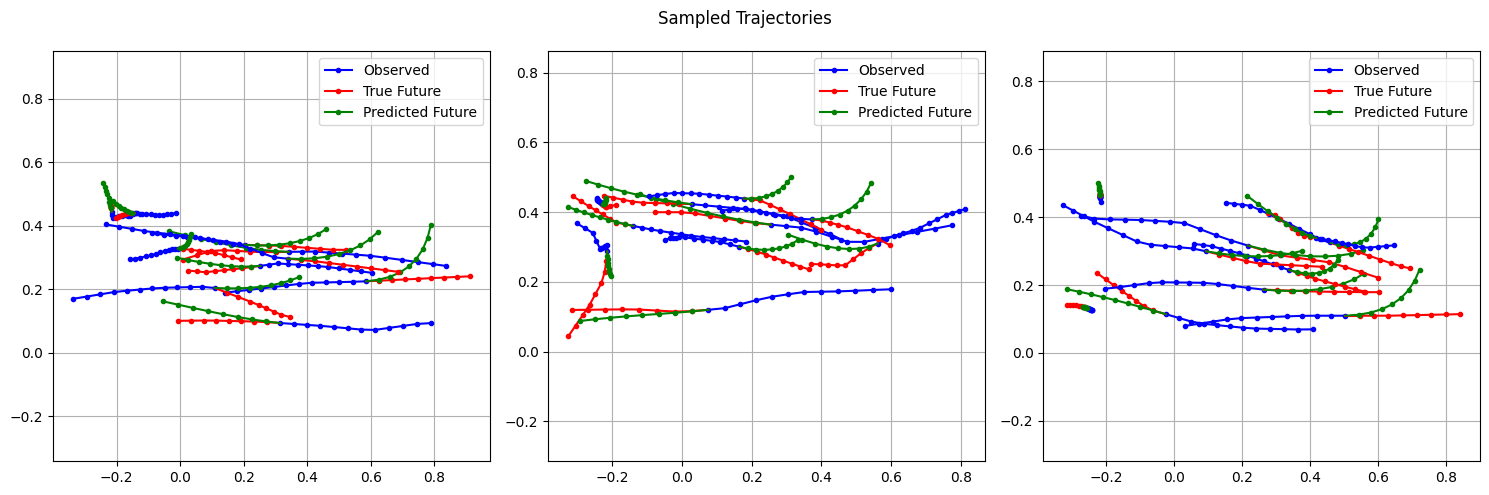

In [ ]:
# Display sampled trajectories using function from above
display_sampled_trajectories(val_observed, val_future, predicted_val_future_simple)

## 4. Second LSTM Model
Implementation of the second LSTM model that follows encoder-decoder network architecture.

Encoder-Decoder LSTM: The second LSTM model follows the encoder-decoder architecture. This architecture is common for sequence-to-sequence prediction tasks. In the context of our task, the encoder LSTM will process the observed part of the trajectories and the decoder will produce the entire future trajectory sequence in one go (or step-by-step). This architecture is particularly useful when there's a need to capture the context of the entire input sequence before producing any part of the output sequence.

In [ ]:
# import numpy as np
# import tensorflow as tf

# # Encoder
# encoder_inputs = tf.keras.layers.Input(shape=(None, 2))
# encoder = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_state=True))
# encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
# encoder_states = [tf.keras.layers.Concatenate()([forward_h, backward_h]), tf.keras.layers.Concatenate()([forward_c, backward_c])]

# # Decoder
# decoder_inputs = tf.keras.layers.Input(shape=(None, 2))
# decoder_lstm = tf.keras.layers.LSTM(64, return_sequences=True)
# decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
# decoder_dense = tf.keras.layers.Dense(2)
# decoder_outputs = decoder_dense(decoder_outputs)

# # Model
# encoder_decoder_model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

# # Early stopping callback
# early_stopping_val_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# early_stopping_loss = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# # Add custom callback to the list
# callbacks_list=[PrintEvery10Epochs(), early_stopping_val_loss, early_stopping_loss]

# # Existing model compilation and data
# encoder_decoder_model.compile(loss=ADE, optimizer="adam")

# # Training data adaptation for this model structure
# X_train_decode = np.zeros_like(train_future)
# X_val_decode = np.zeros_like(val_future)

# # Train the model with verbose set to 0
# history = encoder_decoder_model.fit([train_observed, X_train_decode], train_future, epochs=100,
#                                     validation_data=([val_observed, X_val_decode], val_future),
#                                     callbacks=callbacks_list, verbose=0)

Epoch 0: val_loss = 0.04229561612010002, loss = 0.08176671713590622
Epoch 10: val_loss = 0.0250746738165617, loss = 0.03182824328541756
Epoch 20: val_loss = 0.023299604654312134, loss = 0.029511110857129097
Epoch 30: val_loss = 0.02096611261367798, loss = 0.029123960062861443


removed bidirectional

In [ ]:
import numpy as np
import tensorflow as tf

# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(None, 2))
encoder = tf.keras.layers.LSTM(32, return_state=True)
encoder_outputs, forward_h, forward_c = encoder(encoder_inputs)
encoder_states = [forward_h, forward_c]

# Decoder
decoder_inputs = tf.keras.layers.Input(shape=(None, 2))
decoder_lstm = tf.keras.layers.LSTM(32, return_sequences=True)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = tf.keras.layers.Dense(2)
decoder_outputs = decoder_dense(decoder_outputs)

# Model
encoder_decoder_model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

# Early stopping callback
early_stopping_val_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
early_stopping_loss = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Add custom callback to the list
callbacks_list=[PrintEvery10Epochs(), early_stopping_val_loss, early_stopping_loss]

# Existing model compilation and data
encoder_decoder_model.compile(loss=ADE, optimizer="adam")

# Training data adaptation for this model structure
X_train_decode = np.zeros_like(train_future)
X_val_decode = np.zeros_like(val_future)

# Train the model with verbose set to 0
history = encoder_decoder_model.fit([train_observed, X_train_decode], train_future, epochs=100,
                                    validation_data=([val_observed, X_val_decode], val_future),
                                    callbacks=callbacks_list, verbose=0)

Epoch 0: val_loss = 0.036360178142786026, loss = 0.08791541308164597
Epoch 10: val_loss = 0.02539903298020363, loss = 0.03160719573497772
Epoch 20: val_loss = 0.022046415135264397, loss = 0.02962625026702881
Epoch 30: val_loss = 0.021145762875676155, loss = 0.029276126995682716


In [ ]:
# Show the architecture
encoder_decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, None, 2)]            0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, None, 2)]            0         []                            
                                                                                                  
 lstm_10 (LSTM)              [(None, 32),                 4480      ['input_7[0][0]']             
                              (None, 32),                                                         
                              (None, 32)]                                                         
                                                                                            

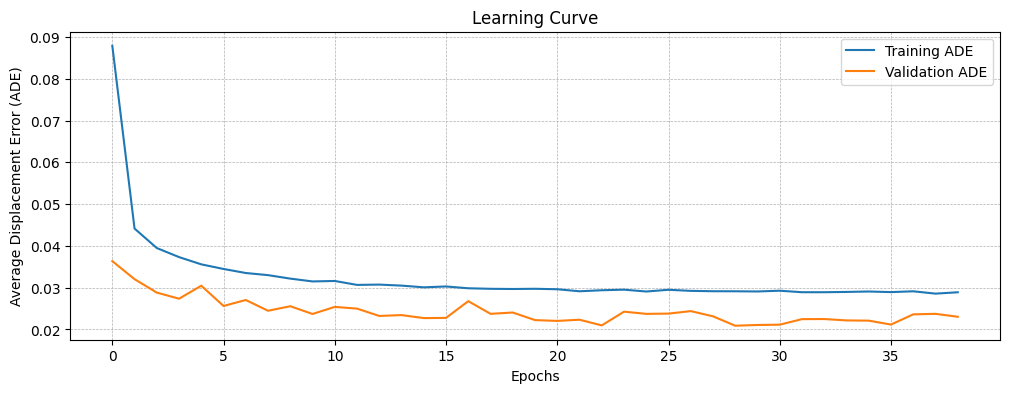

In [ ]:
plot_learning_curves(history)

Plot remaining 7 steps and plot ADE vs time step

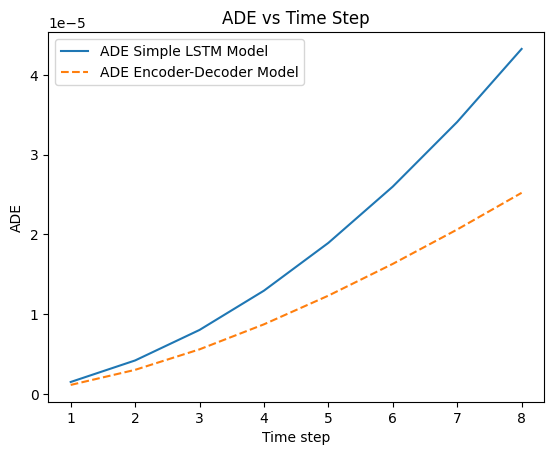

In [ ]:
# Calculate ADE for encoder-decoder model
predicted_val_future_encoder_decoder = predict_and_calculate_ade(val_observed, val_future, encoder_decoder_model, ade_per_step_encoder_decoder, 8, is_encoder_decoder=True)
ade_per_step_encoder_decoder /= num_samples

# Plot ADE for both models
plt.figure()
plt.plot(range(1, 9), ade_per_step_simple, label='ADE Simple LSTM Model')
plt.plot(range(1, 9), ade_per_step_encoder_decoder, label='ADE Encoder-Decoder Model', linestyle='--')
plt.xlabel('Time step')
plt.ylabel('ADE')
plt.legend()
plt.title('ADE vs Time Step')
plt.show()


In [ ]:
# ADE & FDE using the predictions generated by the encoder-decoder model
ade_encoder_decoder = ADE(val_future, predicted_val_future_encoder_decoder)
fde_encoder_decoder = FDE(val_future[:, -1, :], predicted_val_future_encoder_decoder[:, -1, :])
print(f"Encoder-Decoder Model - Average Displacement Error (ADE): {ade_encoder_decoder:.4f}")
print(f"Encoder-Decoder Model - Final Displacement Error (FDE): {fde_encoder_decoder:.4f}")

Encoder-Decoder Model - Average Displacement Error (ADE): 0.0268
Encoder-Decoder Model - Final Displacement Error (FDE): 0.0583


**Display Sampled Trajectories**

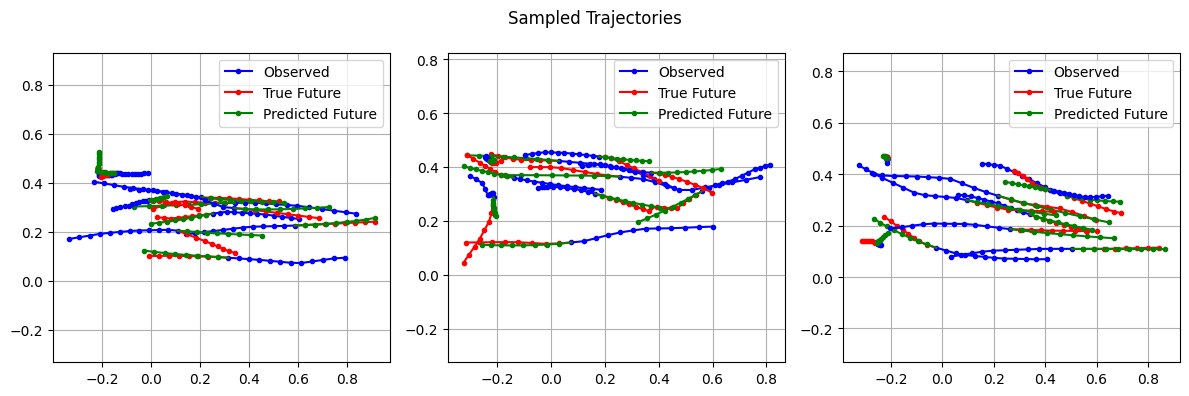

In [ ]:
# Display sampled trajectories using function from above
display_sampled_trajectories(val_observed, val_future, predicted_val_future_encoder_decoder)

## 5. Comparison

Compare the two LSTM models in terms of their numbers of parameters and performances
on the ADE and the FDE.

Which one would perform better?

It depends on the nature of the data and the specific problem you're tackling. Sometimes, the simplicity of the single-step prediction model might work well enough. However, for complex sequential data where future outputs heavily depend on the entirety of the input sequence, the encoder-decoder might perform better because it's designed to capture and utilize the entire input sequence context.
Which one is more complex?

The encoder-decoder LSTM is generally more complex than the single-step LSTM. This is because the encoder-decoder consists of two main parts: the encoder, which processes the input sequence and captures its context, and the decoder, which uses this context to produce the output sequence. The flow of information and the structure in the encoder-decoder LSTM make it more intricate than the single-step LSTM which just repeatedly uses the same LSTM structure to predict one step at a time.

Change the lengths of the observed and future parts to 10/10, 8/12, and 6/142
and compare
how much the performances of both models drop with fewer observed timesteps and more
future timesteps.
Note that you should not need to change the architectures of the two LSTM networks, but
you would need to recompile and retrain the second LSTM model. You can put the code in a
function so that it can be reused for different split ratios of the trajectories.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional, Concatenate
import matplotlib.pyplot as plt

def train_and_evaluate(encoder_decoder_model, simple_model, observed_len, future_len):
    # Split the trajectories based on the new lengths
    train_observed, train_future = split_trajectories(train_set, observed_len, future_len)
    val_observed, val_future = split_trajectories(val_set, observed_len, future_len)

    # Compile and train the second LSTM model (encoder-decoder model)
    encoder_decoder_model.compile(loss=ADE, optimizer="adam")

    # Placeholder for decoder inputs
    X_train_decode = np.zeros_like(train_future)
    X_val_decode = np.zeros_like(val_future)

    # Training the encoder-decoder model
    history = encoder_decoder_model.fit([train_observed, X_train_decode], train_future, epochs=100,
                        validation_data=([val_observed, X_val_decode], val_future),
                        callbacks=callbacks_list, verbose=0)


    # Initialize ADE arrays
    ade_per_step_simple = np.zeros(future_len)
    ade_per_step_encoder_decoder = np.zeros(future_len)
    num_samples = val_observed.shape[0]

    # Calculate ADE for the simple model
    predicted_val_future_simple = predict_and_calculate_ade(val_observed, val_future, simple_model, ade_per_step_simple, future_len)
    ade_per_step_simple /= num_samples


    # Calculate ADE for encoder-decoder model
    predicted_val_future_encoder_decoder = predict_and_calculate_ade(val_observed, val_future, encoder_decoder_model, ade_per_step_encoder_decoder, future_len, is_encoder_decoder=True)
    ade_per_step_encoder_decoder /= num_samples

    # Display sampled trajectories for the simple model
    display_sampled_trajectories(val_observed, val_future, predicted_val_future_simple,
                                 title=f"Simple Model with {observed_len}/{future_len} split", seed=42)

    # Display sampled trajectories for the encoder-decoder model
    display_sampled_trajectories(val_observed, val_future, predicted_val_future_encoder_decoder,
                                 title=f"Encoder-Decoder Model with {observed_len}/{future_len} split", seed=42)


    # Plot ADE
    plt.figure()
    plt.plot(range(1, future_len + 1), ade_per_step_simple, label=f'ADE Simple Model with {observed_len}/{future_len} split')
    plt.plot(range(1, future_len + 1), ade_per_step_encoder_decoder, label=f'ADE Encoder-Decoder Model with {observed_len}/{future_len} split', linestyle='--')
    plt.xlabel('Time step')
    plt.ylabel('ADE')
    plt.legend()
    plt.title('ADE vs Time Step')
    plt.show()

Epoch 0: val_loss = 0.02784775197505951, loss = 0.03838174417614937
Epoch 10: val_loss = 0.0292445607483387, loss = 0.037360288202762604
Epoch 20: val_loss = 0.030614318326115608, loss = 0.03699777275323868


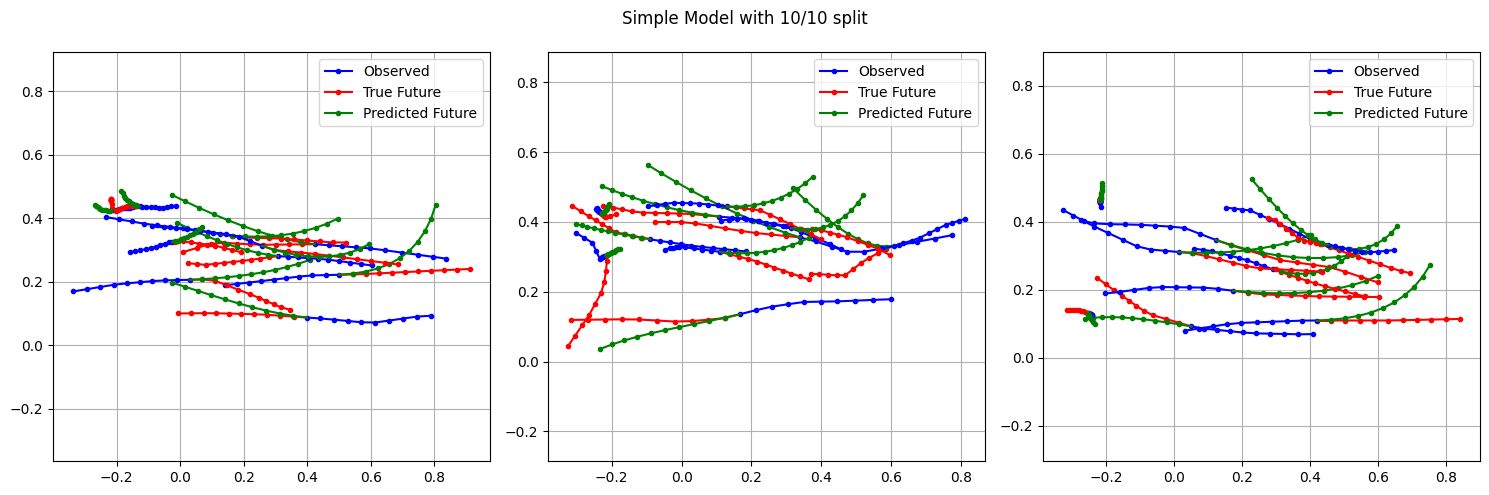

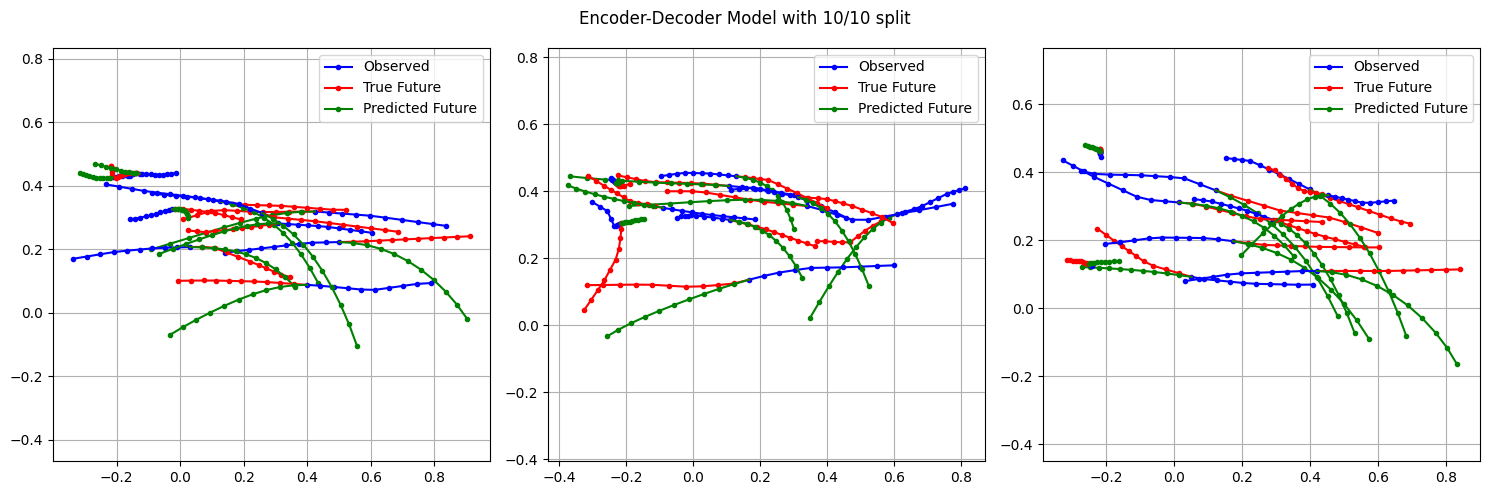

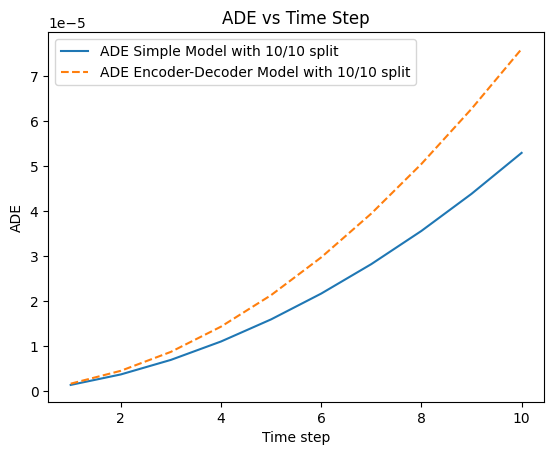

Epoch 0: val_loss = 0.03517627716064453, loss = 0.04673238471150398
Epoch 10: val_loss = 0.035022858530282974, loss = 0.04570768028497696


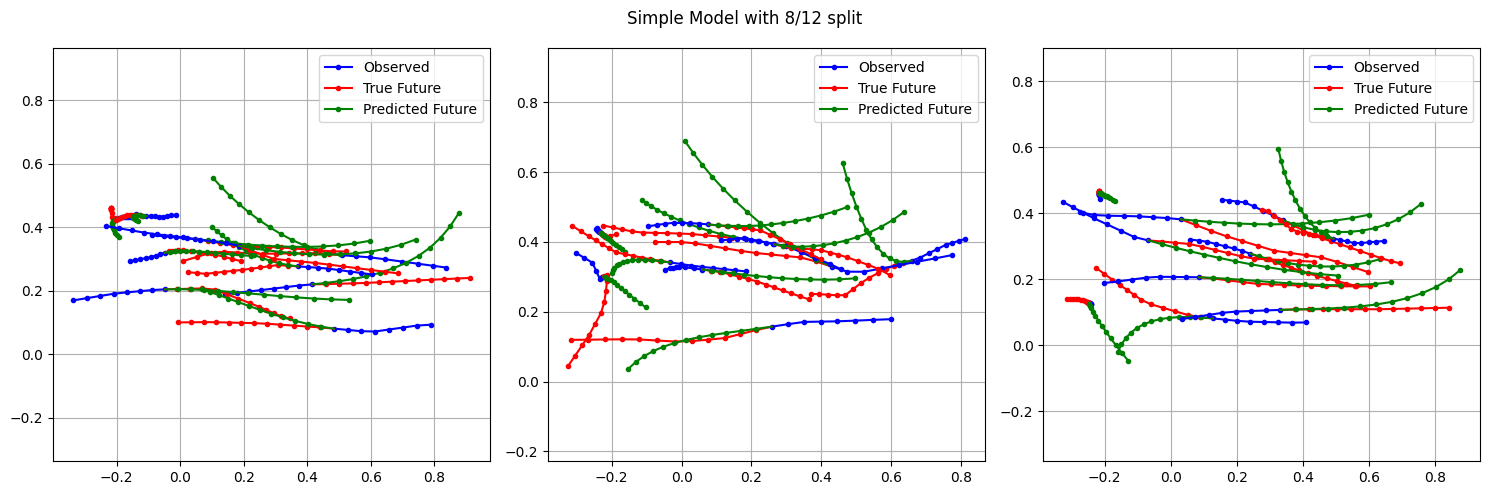

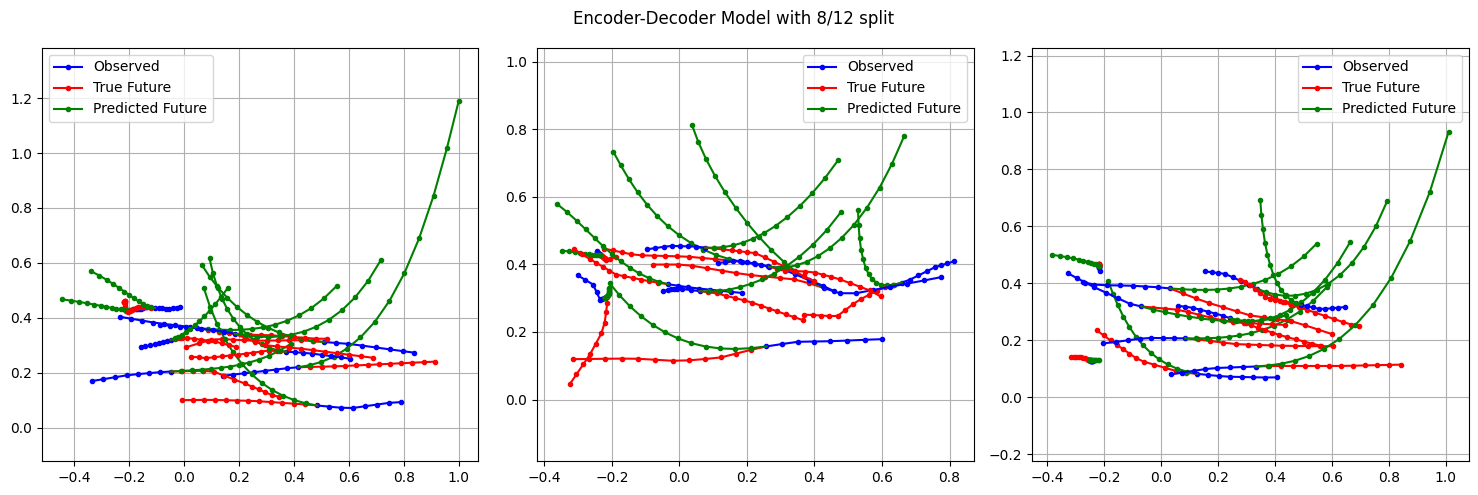

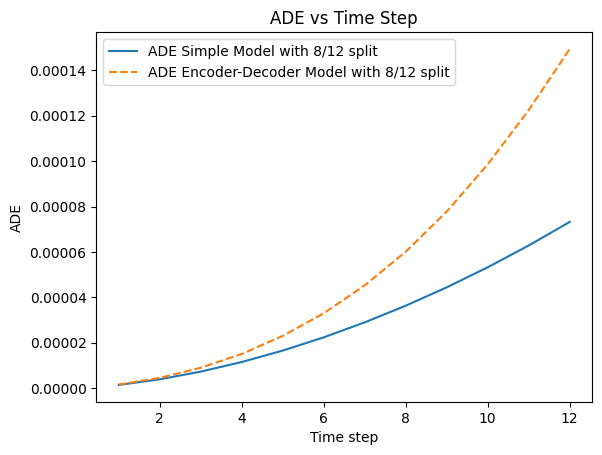

Epoch 0: val_loss = 0.04207079857587814, loss = 0.05589824542403221
Epoch 10: val_loss = 0.039915572851896286, loss = 0.054447662085294724
Epoch 20: val_loss = 0.04428974539041519, loss = 0.053989920765161514


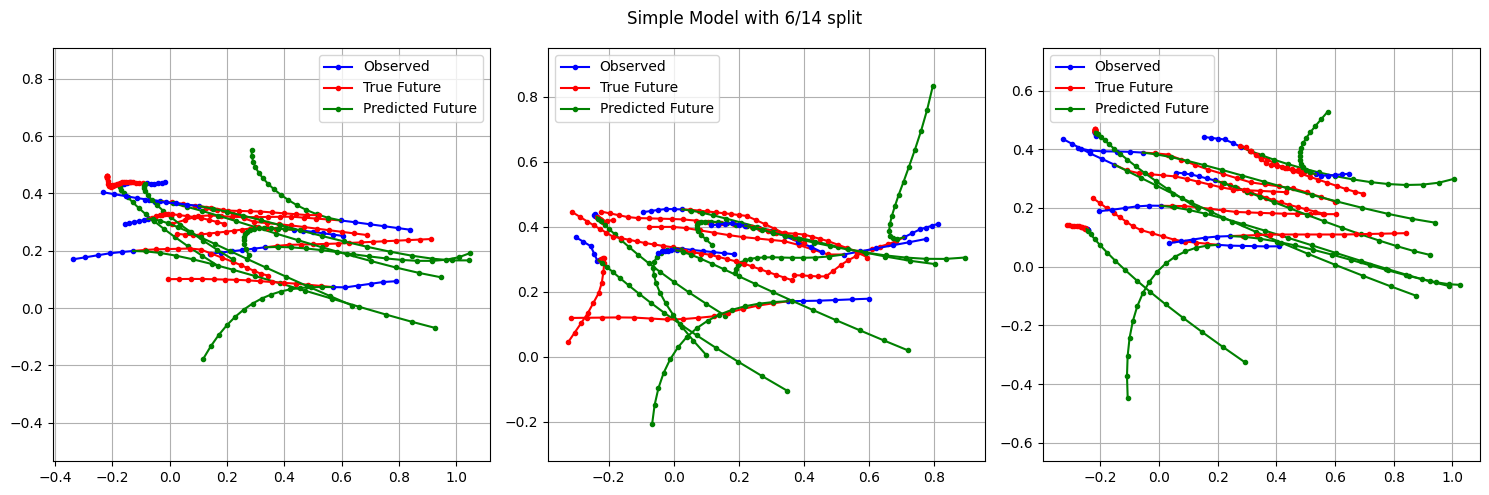

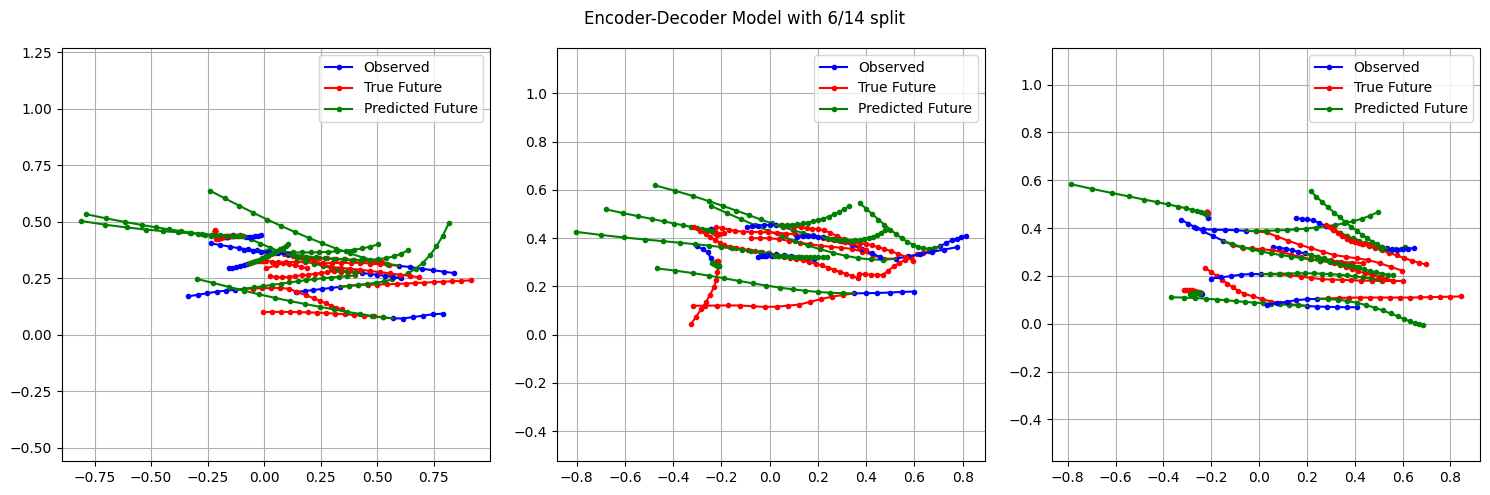

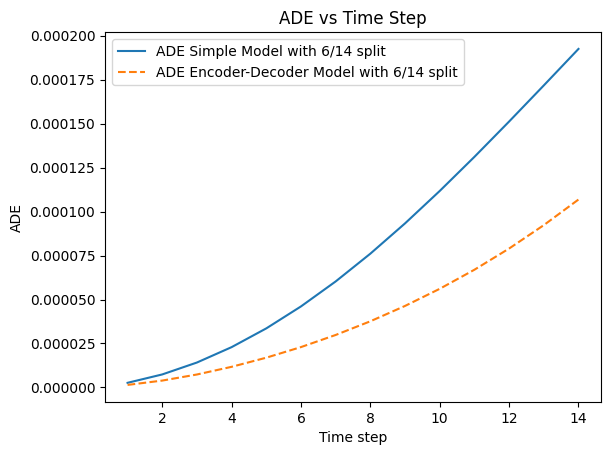

In [ ]:
# different observed/future lengths
train_and_evaluate(encoder_decoder_model, simple_model, 10, 10)
train_and_evaluate(encoder_decoder_model, simple_model, 8, 12)
train_and_evaluate(encoder_decoder_model, simple_model, 6, 14)

## Trajectory generation

Implement a variational autoencoder (VAE) that can generate trajectories of 20 frames long. Here,
you don’t need to split the trajectories into observed and future parts. Use the training set to
train your VAE model and the validation set for validation. You loss function should include the
reconstruction loss (LADE in Equation (1)) and the latent loss. Show the architecture of your VAE
network. You can try training the network for 100 epochs with early stopping or try other settings.
Show the learning curves plot.
Illustrate 30 generated trajectories from your model in subplots. Comment on the quality of the
generated trajectories.

Epoch 0: val_loss = 0.26317521929740906, loss = 0.2825044095516205
Epoch 10: val_loss = 0.19062986969947815, loss = 0.19616347551345825
Epoch 20: val_loss = 0.1873549073934555, loss = 0.19298599660396576


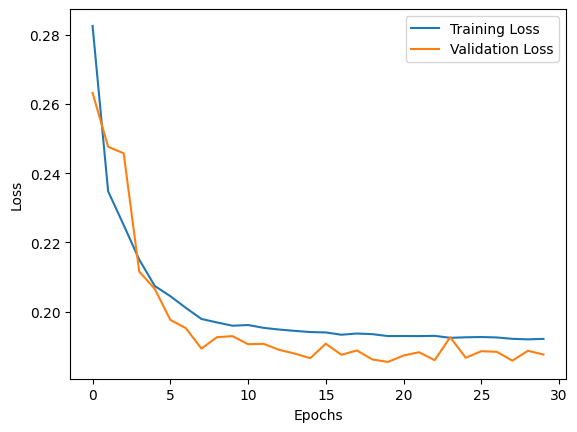

In [ ]:
# Define a customized sampling layer
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# The encoder part of the VAE
encoder_inputs = tf.keras.layers.Input(shape=(20, 2))
x = tf.keras.layers.LSTM(64, return_sequences=True)(encoder_inputs)
x = tf.keras.layers.LSTM(32)(x)
z_mean = tf.keras.layers.Dense(16)(x)
z_log_var = tf.keras.layers.Dense(16)(x)
z = Sampling()([z_mean, z_log_var])
variational_encoder = tf.keras.Model(inputs=[encoder_inputs], outputs=[z_mean, z_log_var, z])

# The decoder part of the VAE
decoder_inputs = tf.keras.layers.Input(shape=(16))  # 16 is the size of the latent space
x_decoded = tf.keras.layers.Dense(32, activation='relu')(decoder_inputs)
x_decoded = tf.keras.layers.RepeatVector(20)(x_decoded)
x_decoded = tf.keras.layers.LSTM(32, return_sequences=True)(x_decoded)
x_decoded = tf.keras.layers.LSTM(64, return_sequences=True)(x_decoded)
x_decoded_mean = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(2))(x_decoded)

# Now join the encoder and decoder together to form our VAE
_, _, codings = variational_encoder(encoder_inputs)
reconstructions = tf.keras.Model(decoder_inputs, x_decoded_mean)(codings)
variational_ae = tf.keras.Model(inputs=[encoder_inputs], outputs=[reconstructions])

# Create the standalone decoder model immediately after defining the full VAE
decoder_model = tf.keras.Model(inputs=decoder_inputs, outputs=x_decoded_mean)

# Add the latent loss
latent_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.exp(z_log_var) - tf.square(z_mean), axis=-1)
latent_loss = tf.reduce_mean(latent_loss) / 40  # 20 * 2 = 40, considering both time steps and features
variational_ae.add_loss(latent_loss)

# Early stopping
early_stopping_val_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
early_stopping_loss = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Add custom callback to the list
callbacks_list=[PrintEvery10Epochs(), early_stopping_val_loss, early_stopping_loss]

# Compile and train the VAE
variational_ae.compile(optimizer='adam', loss=ADE)

# Train the model
vae_history = variational_ae.fit(train_set, train_set, epochs=100, batch_size=32, validation_data=(val_set, val_set), callbacks=callbacks_list, verbose=0)

# Plot training and validation loss
plt.plot(vae_history.history['loss'], label='Training Loss')
plt.plot(vae_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Model architecture
variational_ae.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 20, 2)]              0         []                            
                                                                                                  
 model_10 (Functional)       [(None, 16),                 30624     ['input_9[0][0]']             
                              (None, 16),                                                         
                              (None, 16)]                                                         
                                                                                                  
 model_11 (Functional)       (None, 20, 2)                33826     ['model_10[0][2]']            
                                                                                           

In [ ]:
# # Generate new trajectories
# n_samples = 30
# random_latent_vectors = np.random.normal(size=(n_samples, 16))

# # Use only the decoder to generate data
# decoder_model = tf.keras.Model(decoder_inputs, x_decoded_mean)
# generated_data = decoder_model.predict(random_latent_vectors)

# # Display
# display_sampled_trajectories(generated_data, generated_data, connect=False)


In [ ]:
print(decoder_inputs)
print(x_decoded_mean)

KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name='input_10'), name='input_10', description="created by layer 'input_10'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name=None), name='time_distributed_1/Reshape_1:0', description="created by layer 'time_distributed_1'")


1/1 [==============================] - 0s 24ms/step


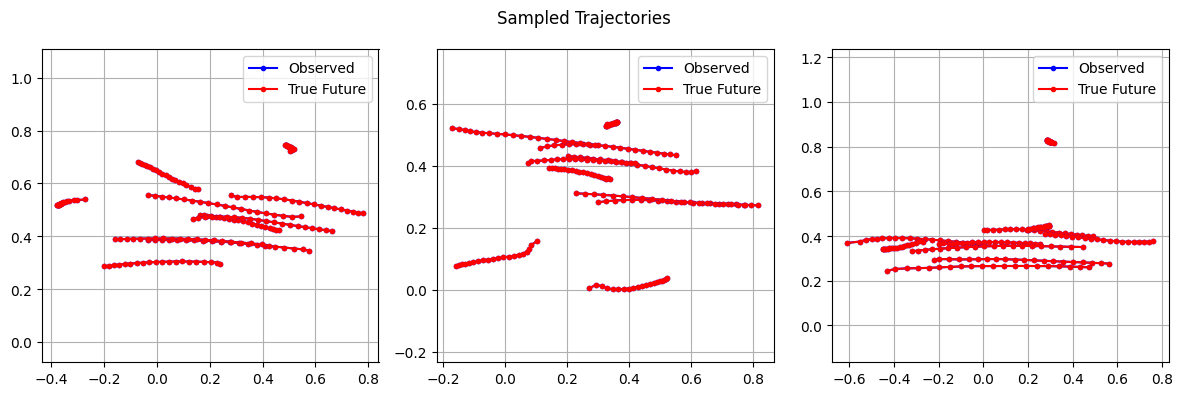

In [ ]:
# Generate new trajectories
n_samples = 30
random_latent_vectors = np.random.normal(size=(n_samples, 16))
generated_data = decoder_model.predict(random_latent_vectors)

# Display
display_sampled_trajectories(generated_data, generated_data, connect=False)

- Show the original trajectories.